<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [1]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [2]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

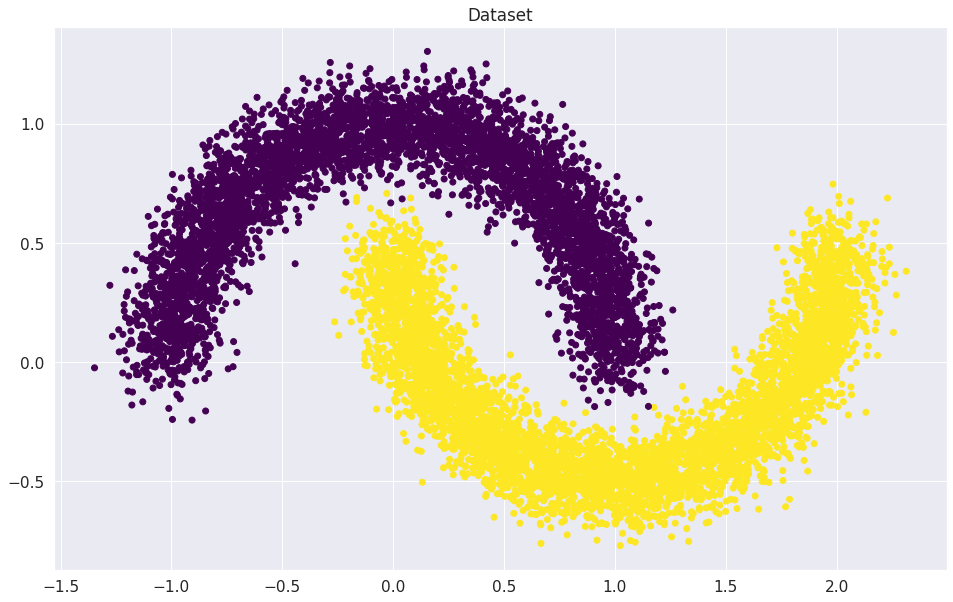

In [3]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

In [5]:
X_train[0]

array([ 0.50202001, -0.33758011])

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [6]:
X_train_t =  torch.FloatTensor(X_train)# YOUR CODE GOES HERE
y_train_t =  torch.FloatTensor(y_train)# YOUR CODE GOES HERE
X_val_t =  torch.FloatTensor(X_val)# YOUR CODE GOES HERE
y_val_t =  torch.FloatTensor(y_val)# YOUR CODE GOES HERE

Создаем `Dataset` и `DataLoader`. 

In [7]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут 
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [16]:
device = torch.device('cuda:0') if torch.cuda.is_available else torch.device('cpu')  
device

device(type='cuda', index=0)

In [17]:
X_train

NameError: ignored

In [10]:
nn.Parameter(torch.randn(128, 2))

Parameter containing:
tensor([[ 0.5673,  0.9532],
        [ 0.0909,  0.7908],
        [ 0.3787, -1.1122],
        [-1.1999,  1.7108],
        [ 1.3746,  0.9277],
        [ 0.5970, -0.2877],
        [-0.3708, -0.3404],
        [-0.3769,  2.0343],
        [ 0.4684,  0.7394],
        [-1.2882,  1.2777],
        [-0.6478, -1.4273],
        [ 0.8956, -0.1918],
        [ 1.0442, -1.5924],
        [ 1.7392,  0.7399],
        [ 0.1232, -0.5224],
        [ 0.5701,  0.5045],
        [ 0.2791, -0.3836],
        [ 0.0386,  1.2224],
        [-0.0657,  0.2950],
        [-0.1279, -1.0662],
        [-0.5515, -0.4556],
        [-0.3108,  0.0894],
        [ 1.8635, -0.4712],
        [-0.6435, -1.8235],
        [ 0.6137,  0.4787],
        [ 0.4713, -1.1155],
        [-1.5875,  1.9963],
        [-0.2127, -0.0913],
        [ 0.7384,  1.0618],
        [-0.1303,  0.0187],
        [ 1.4844,  0.4667],
        [ 0.6540, -1.2752],
        [ 1.9419, -1.8407],
        [-0.9715, -0.8723],
        [-0.3770,  1.7710]

In [11]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features, out_features))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features))# YOUR CODE GOES HERE

    def forward(self, x):
        x =  x @ self.weights# YOUR CODE GOES HERE
        if self.bias:
            x +=  self.bias_term # YOUR CODE GOES HERE
        return x

In [12]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели?

##2


### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [14]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp =  linear_regression.forward(X_batch)# YOUR CODE. Use linear_regression to get outputs
        loss =  loss_function(outp[:, 0], y_batch)# YOUR CODE. Compute loss
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities = 1/(1+torch.exp(-outp)) # YOUR CODE. Compute probabilities
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)
        
        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.5859375
Iteration: 100
Batch accuracy: 0.875
Iteration: 200
Batch accuracy: 0.8671875
Iteration: 300
Batch accuracy: 0.921875
Iteration: 400
Batch accuracy: 0.8984375
Iteration: 500
Batch accuracy: 0.9140625

Iteration: 523.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:** 523


### Визуализируем результаты

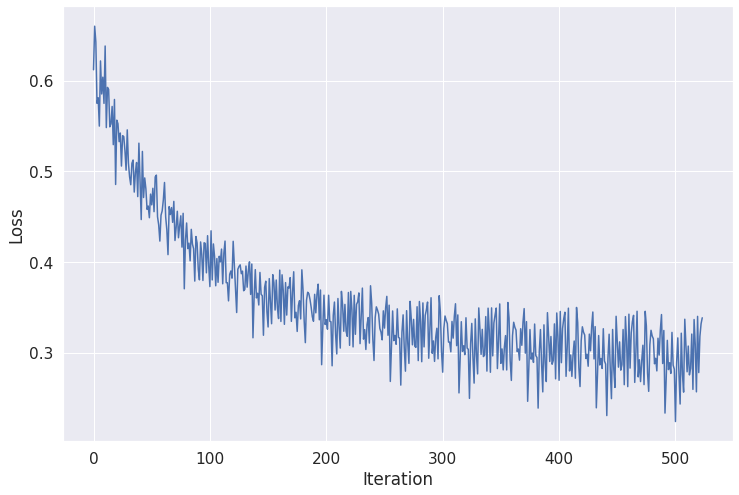

In [15]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

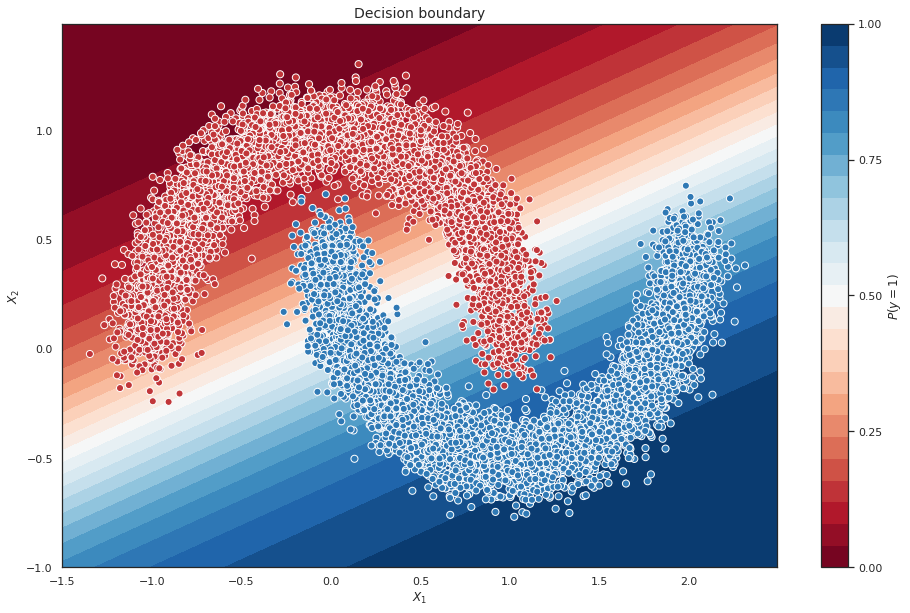

In [16]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [17]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        
        preds = torch.round(1/(1+torch.exp(-linear_regression.forward(x_batch))))#YOUR CODE. Compute predictions
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [18]:
y_val_t.data.numpy()

array([1., 1., 0., ..., 1., 0., 0.], dtype=float32)

In [19]:
np.array(predict(val_dataloader, linear_regression), dtype='float32')

array([1., 1., 0., ..., 1., 0., 0.], dtype=float32)

In [20]:
from sklearn.metrics import accuracy_score
print(accuracy_score(np.array(predict(val_dataloader, linear_regression), dtype='float32'), y_val_t.data.numpy()))

0.8788


**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** 0.8788


# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [14]:
import os
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as tfs
batch_size = 128


data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader =  DataLoader(train_dataset, batch_size=batch_size, drop_last=True)# YOUR CODE GOES HERE
valid_dataloader =  DataLoader(val_dataset, batch_size=batch_size, drop_last=True)# YOUR CODE GOES HERE

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [63]:
class Identical(nn.Module):
    def forward(self, x):
        return x

In [23]:
train_dataset.data.shape

torch.Size([60000, 28, 28])

### Задание. Простая полносвязная нейронная сеть 

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [64]:
activation = nn.ELU

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 128),
    nn.ELU(),
    nn.Linear(128, 128),
    nn.ELU(),
    nn.Linear(128, 10)
    
    #YOUR CODE. Add layers to your sequential class
)

In [65]:
from torch.nn.functional import cross_entropy
criterion = cross_entropy #YOUR CODE. Select a loss function
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [66]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [67]:
from torch.nn.functional import cross_entropy
max_epochs = 10
accuracy = {"train": [], "valid": []}

criterion = cross_entropy #YOUR CODE. Select a loss function
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)
                 # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch)
                 # YOUR CODE. Set model to ``eval`` mode and calculate outputs
            preds = outp.argmax(-1)
            correct = len(preds[preds == y_batch]) # YOUR CODE GOES HERE
            all = len(preds) # YOUR CODE GOES HERE
            epoch_correct += correct
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
                # YOUR CODE. Calculate gradients and make a step of your optimizer
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.8806423611111112
Loader: valid. Accuracy: 0.9337940705128205
Epoch: 2
Loader: train. Accuracy: 0.9419571314102564
Loader: valid. Accuracy: 0.9545272435897436
Epoch: 3
Loader: train. Accuracy: 0.9597188835470085
Loader: valid. Accuracy: 0.9624399038461539
Epoch: 4
Loader: train. Accuracy: 0.9684995993589743
Loader: valid. Accuracy: 0.9647435897435898
Epoch: 5
Loader: train. Accuracy: 0.9740584935897436
Loader: valid. Accuracy: 0.9672475961538461
Epoch: 6
Loader: train. Accuracy: 0.9786157852564102
Loader: valid. Accuracy: 0.9667467948717948
Epoch: 7
Loader: train. Accuracy: 0.9820546207264957
Loader: valid. Accuracy: 0.9628405448717948
Epoch: 8
Loader: train. Accuracy: 0.9842748397435898
Loader: valid. Accuracy: 0.9672475961538461
Epoch: 9
Loader: train. Accuracy: 0.9859274839743589
Loader: valid. Accuracy: 0.9722556089743589
Epoch: 10
Loader: train. Accuracy: 0.9856436965811965
Loader: valid. Accuracy: 0.97265625


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [68]:
elu_accuracy = accuracy["valid"]

In [69]:
# YOUR CODE. Do the same thing with other activations (it's better to wrap into a function that returns a list of accuracies)
from torch.nn.functional import cross_entropy
def test_activation_function(activation):
    train_dataloader =  DataLoader(train_dataset, batch_size=batch_size, drop_last=True)# YOUR CODE GOES HERE
    valid_dataloader =  DataLoader(val_dataset, batch_size=batch_size, drop_last=True)# YOUR CODE GOES HERE

    max_epochs = 10
    accuracy = {"train": [], "valid": []}

    

    loaders = {"train": train_dataloader, "valid": valid_dataloader}
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(784, 128),
        activation,
        nn.Linear(128, 128),
        activation,
        nn.Linear(128, 10)
    )
    criterion = cross_entropy #YOUR CODE. Select a loss function
    optimizer = torch.optim.Adam(model.parameters())
    max_epochs = 10
    accuracy = {"train": [], "valid": []}
    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                if k == "train":
                    model.train()
                    optimizer.zero_grad()
                    outp = model(x_batch)
                     # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
                else:
                    model.eval()
                    with torch.no_grad():
                        outp = model(x_batch)
                     # YOUR CODE. Set model to ``eval`` mode and calculate outputs
                preds = outp.argmax(-1)
                correct = len(preds[preds == y_batch]) # YOUR CODE GOES HERE
                all = len(preds) # YOUR CODE GOES HERE
                epoch_correct += correct
                epoch_all += all
                if k == "train":
                    loss = criterion(outp, y_batch)
                    loss.backward()
                    optimizer.step()
                    # YOUR CODE. Calculate gradients and make a step of your optimizer
            if k == "train":
                print(f"Epoch: {epoch+1}")
            print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
            accuracy[k].append(epoch_correct/epoch_all)
    return accuracy

In [70]:
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU())
plain_accuracy = test_activation_function(Identical())
relu_accuracy = test_activation_function(nn.ReLU())#YOUR CODE
#YOUR CODE

Epoch: 1
Loader: train. Accuracy: 0.8675380608974359
Loader: valid. Accuracy: 0.9272836538461539
Epoch: 2
Loader: train. Accuracy: 0.9360643696581197
Loader: valid. Accuracy: 0.9498197115384616
Epoch: 3
Loader: train. Accuracy: 0.9538094284188035
Loader: valid. Accuracy: 0.9567307692307693
Epoch: 4
Loader: train. Accuracy: 0.9642427884615384
Loader: valid. Accuracy: 0.9638421474358975
Epoch: 5
Loader: train. Accuracy: 0.9704527243589743
Loader: valid. Accuracy: 0.9644431089743589
Epoch: 6
Loader: train. Accuracy: 0.9744257478632479
Loader: valid. Accuracy: 0.9639423076923077
Epoch: 7
Loader: train. Accuracy: 0.9771133814102564
Loader: valid. Accuracy: 0.9681490384615384
Epoch: 8
Loader: train. Accuracy: 0.9801181891025641
Loader: valid. Accuracy: 0.9666466346153846
Epoch: 9
Loader: train. Accuracy: 0.9819210737179487
Loader: valid. Accuracy: 0.9631410256410257
Epoch: 10
Loader: train. Accuracy: 0.9844250801282052
Loader: valid. Accuracy: 0.9611378205128205
Epoch: 1
Loader: train. Accur

In [ ]:
print(leaky_relu_accuracy['valid'])

[0.9253806089743589, 0.9436097756410257, 0.9544270833333334, 0.9599358974358975, 0.9566306089743589, 0.9529246794871795, 0.9552283653846154, 0.9555288461538461, 0.9582331730769231, 0.9668469551282052]


### Accuracy
Построим график accuracy/epoch для каждой функции активации.

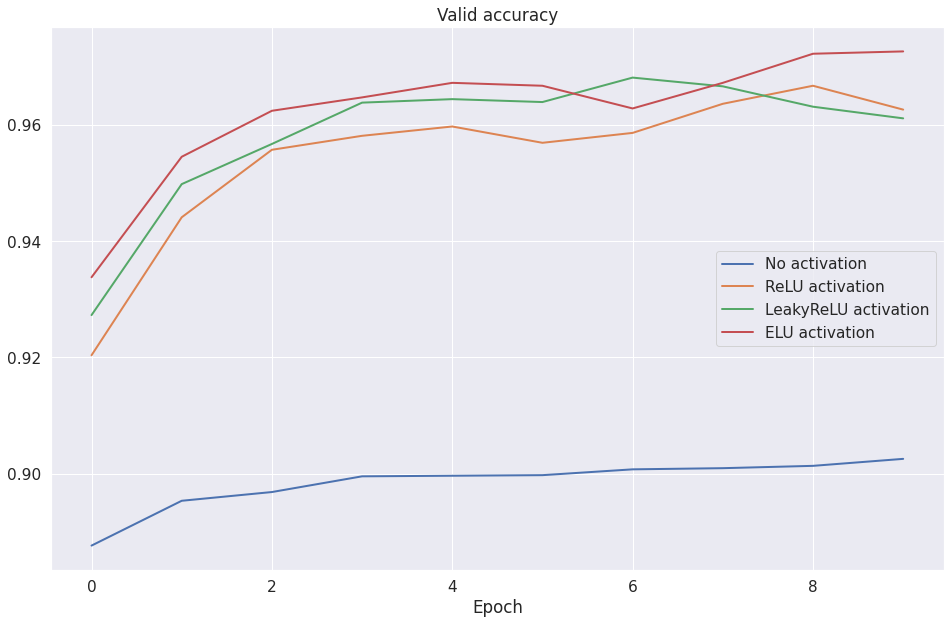

In [71]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy['valid'], label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy['valid'], label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy['valid'], label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

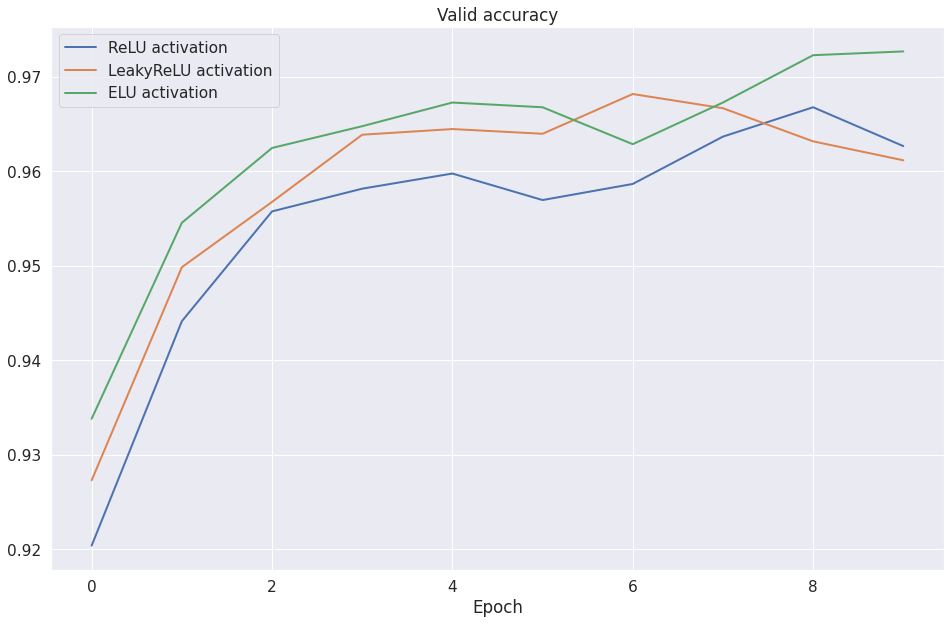

In [72]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy['valid'], label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy['valid'], label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:**ELU

In [ ]:
#ELU

In [10]:
device = 'cuda'

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [23]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2022-07-23 00:25:38--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 144.76.208.75
Connecting to img.the-village.kz (img.the-village.kz)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg [following]
--2022-07-23 00:25:39--  https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village-kz.com (img.the-village-kz.com)... 144.76.208.75
Connecting to img.the-village-kz.com (img.the-village-kz.com)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K   164KB/s    in 0.3s    

2022-07-23 00:25:40 (164 KB/s) - ‘sample_photo.jpg’ saved [49337/4

In [26]:
import seaborn as sns
from matplotlib import pyplot as plt

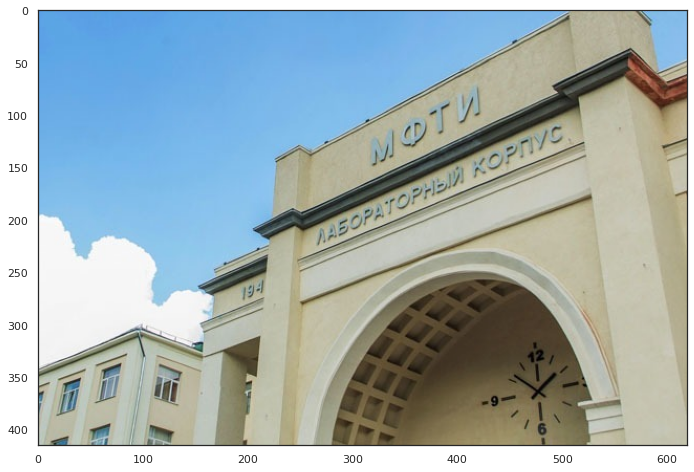

In [77]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте 
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [90]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

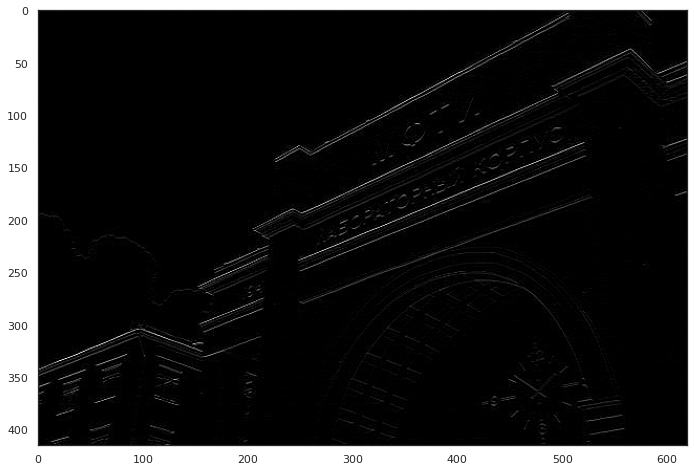

In [91]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:**E, Д, A, В, Б, Г


### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential). 

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [4]:
from torch import nn

In [42]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)#YOUR CODE
        self.conv2 = nn.Conv2d(6, 16, 3)#YOUR CODE
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)#YOUR CODE
        self.fc1 = nn.Linear(400, 120) #YOUR CODE  
        self.fc2 = nn.Linear(120, 84)#YOUR CODE
        self.fc3 = nn.Linear(84, 10)#YOUR CODE

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))#YOUR CODE. Apply layers created in __init__. 
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 5 * 5 * 16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [1]:
from tqdm import tqdm_notebook

In [21]:
import torch
import torch.nn.functional as F

TypeError: ignored

In [54]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [47]:
import numpy as np

In [44]:
from torchsummary import summary
summary(model.cuda(), (1,28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 26, 26]              60
         MaxPool2d-2            [-1, 6, 13, 13]               0
            Conv2d-3           [-1, 16, 11, 11]             880
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 60,074
Trainable params: 60,074
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.23
Estimated Total Size (MB): 0.29
----------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


  0%|          | 0/468 [00:00<?, ?it/s]

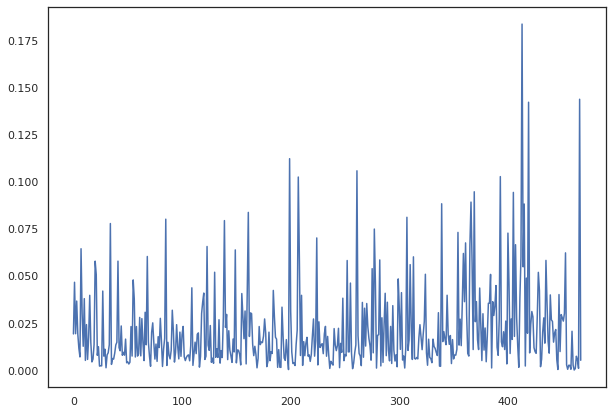

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


  0%|          | 0/468 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


  0%|          | 0/468 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


  0%|          | 0/468 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


  0%|          | 0/468 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


  0%|          | 0/468 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


  0%|          | 0/468 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


  0%|          | 0/468 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


  0%|          | 0/468 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


  0%|          | 0/468 [00:00<?, ?it/s]

Обучение закончено


In [51]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1, 1, 1)
losses = []
# итерируемся
for epoch in tqdm_notebook(range(max_epochs)):

    running_loss = 0.0
    for i, batch in enumerate(tqdm_notebook(dataloader)):
        X_batch, y_batch = batch
        
        optimizer.zero_grad()

        y_pred = model(X_batch.to(device))
        loss = criterion(y_pred.to(device), y_batch.to(device))
        loss.backward()
        optimizer.step()

        # выведем текущий loss
        running_loss += loss.item()
        # выведем качество каждые 2000 батчей

        losses.append(running_loss)
        running_loss = 0.0

    ax.clear()
    ax.plot(np.arange(len(losses)), losses)
    plt.show()

print('Обучение закончено')

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [58]:

train_dataloader =  DataLoader(train_dataset, batch_size=batch_size, drop_last=True)# YOUR CODE GOES HERE
valid_dataloader =  DataLoader(val_dataset, batch_size=batch_size, drop_last=True)# YOUR CODE GOES HERE

max_epochs = 10
accuracy = {"train": [], "valid": []}

model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch.to(device))
                  # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch.to(device))
                  # YOUR CODE. Set model to ``eval`` mode and calculate outputs
            preds = outp.argmax(-1).to(device)
            correct = len(preds[preds == y_batch.to(device)]) # YOUR CODE GOES HERE
            all = len(preds) # YOUR CODE GOES HERE
            epoch_correct += correct
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch.to(device))
                loss.backward()
                optimizer.step()
                # YOUR CODE. Calculate gradients and make a step of your optimizer
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.8726128472222222
Loader: valid. Accuracy: 0.9634415064102564
Epoch: 2
Loader: train. Accuracy: 0.9684161324786325
Loader: valid. Accuracy: 0.9749599358974359
Epoch: 3
Loader: train. Accuracy: 0.9784488514957265
Loader: valid. Accuracy: 0.9783653846153846
Epoch: 4
Loader: train. Accuracy: 0.9832064636752137
Loader: valid. Accuracy: 0.9798677884615384
Epoch: 5
Loader: train. Accuracy: 0.9863782051282052
Loader: valid. Accuracy: 0.9802684294871795
Epoch: 6
Loader: train. Accuracy: 0.988815438034188
Loader: valid. Accuracy: 0.9817708333333334
Epoch: 7
Loader: train. Accuracy: 0.9906850961538461
Loader: valid. Accuracy: 0.9844751602564102
Epoch: 8
Loader: train. Accuracy: 0.9921040331196581
Loader: valid. Accuracy: 0.9855769230769231
Epoch: 9
Loader: train. Accuracy: 0.9929387019230769
Loader: valid. Accuracy: 0.9855769230769231
Epoch: 10
Loader: train. Accuracy: 0.9939236111111112
Loader: valid. Accuracy: 0.9852764423076923


In [60]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

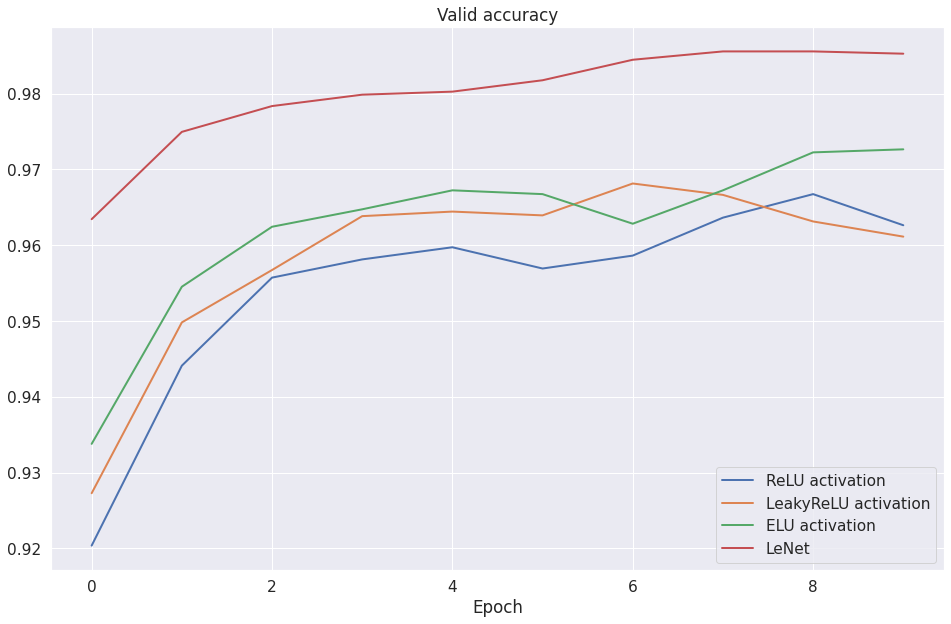

In [74]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy['valid'], label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy['valid'], label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:**0.99